# Multi-Agent Artificial Intellgience, group coursework
## Problem 2: Basic Bidding Strategies

In [1]:
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
with open('./data/validation.csv') as csv_file2: 
    df_val = pd.read_csv(csv_file2)
df_val = df_val[["click","bidprice","payprice"]]
list(df_val.shape)

[303925, 3]

In [4]:
print(df_val.payprice.mean())
groups_val= df_val.groupby('click')
groups_val.bidprice.agg(['count', 'min', 'max', 'mean', 'median', 'std']).round(decimals=2)

78.23400509994242


,count,min,max,mean,median,std
click,,,,,,
0,303723,227,300,273.05,294,28.89
1,202,227,300,273.93,277,28.15


In [108]:
groups_val.payprice.agg(['count', 'min', 'max', 'mean', 'median', 'std']).round(decimals=2)

,count,min,max,mean,median,std
click,,,,,,
0,303723,0,300,78.22,68,60.02
1,202,6,300,105.72,80,68.69


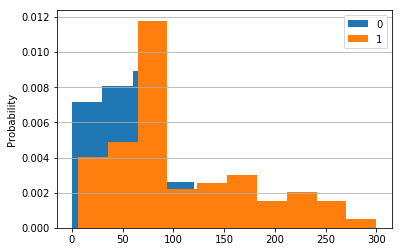

In [109]:
fig, ax = plt.subplots()
# groups_val.payprice.plot.kde(ax=ax, legend=True, title='Histogram: clicked vs. non-clicked prices')
groups_val.payprice.plot.hist(density=True, legend =True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')

### Optimal Constant Bidding: 
In the following, we will assume we participate in each auction on the validation set as a new participant. We win the auction if our bid is strictly higher than the best bid, and if we win, we pay the best-bid price in the auction (Not the pay price). We evaluate every constant bid between the minimum (227) and maximum  (300) bids in the validation dataset and return the optimal constant bid based on number of clicks. We select which auction we win by randomly sampling, over 100 iterations, from the set of winnable auctions given our bid, until we exhaust the budget on each iteration. 

In [110]:
budget = 6250 # budget in fen 

In [111]:
# Evaluate constant bid through a single sample of wins 
def sample_eval_bid(bid, wins):
    #
    # # Create dataframe (wins) with ONLY "winnable" auctions at this bid. Get total number of wins and cost.
    # wins = dataset[dataset.payprice < bid]

    total_wins = wins.shape[0]
    total_cost = wins.payprice.sum() / 1000
    # The total number of clicks if no budget constraint with this bid level
    max_clicks = wins.click.sum()

    # Initialise vars
    won_clicks = 0
    rem_budget = budget
    count = 0

    # Budget allows buying all won ads (low bids)
    if total_cost <= budget:
        won_clicks = max_clicks
        count = total_wins
        rem_budget = budget - total_cost

    # Budget allows only fraction of ads to be bought
    else:
        while rem_budget > bid:

            num_auctions = wins.shape[0]
            N = int(rem_budget * 1000 / wins.payprice.max())

            # Otherwise sample from auctions we can win (once)
            if N < num_auctions:
                batch = wins.sample(n=N)
                # print("current batch shape: {}".format(batch.shape))
                count += N
                won_clicks += batch['click'].sum()
                rem_budget -= batch['payprice'].sum() / 1000

                # Drop the auctions from df
                wins = wins.drop(batch.index)
                # print("number of auctions remaining in df is {}".format(df.shape))
            else:
                count += num_auctions
                won_clicks += wins.click.sum()
                rem_budget -= wins.payprice.sum() / 1000

    return won_clicks, count, rem_budget


In [112]:
# Evaluate constant bid from dataset through repeated sampling of wins 
def eval_const_bid(bid,dataset = df_val, iter = 10):

    clicks = []
    counts = []
    budget_left = []

    # Create dataframe(relevant) with auctions whose best bid is lower than b (otherwise we can't win it)
    wins = dataset[dataset.payprice < bid]

    for _ in range(iter):
        temp_clicks , count, rem_budget = sample_eval_bid(bid,wins)
        clicks.append(temp_clicks)
        counts.append(count)
        budget_left.append(rem_budget)

    exp_clicks = sum(clicks) / len(clicks)
    exp_count = sum(counts) / len(counts)
    exp_budget = sum(budget_left) / len(budget_left)

    if exp_count == 0 :
        ctr = 0
    else:
        ctr = exp_clicks/exp_count

    return exp_clicks, ctr, exp_budget

In [113]:
# Get optimal bid from datatset through systematic search 
def get_best_bid(dataset = df_val,iter = 10):

    min_bid= dataset.payprice.min()
    max_bid = dataset.payprice.max()
    max_clicks = 0
    best_bid = 0
    best_ctr = 0
    left_budget = 0

    for bid in range(min_bid,max_bid+1):
        exp_clicks, ctr , exp_budget = eval_const_bid(bid,dataset, iter)
        
        ###### Visualise the results for each bid 
        print((bid,exp_clicks, round(100*ctr,3) , round(exp_budget,2)))
        #######
        
        if (exp_clicks > max_clicks) and (exp_budget < bid):
            best_bid = bid
            max_clicks = exp_clicks
            best_ctr = ctr
            left_budget = exp_budget

    return best_bid, max_clicks, round(100*best_ctr,3), round(left_budget,2)

In [121]:
print(" Best bid: {} \n Expected number of clicks: {} \n CTR: {} \n Remaining budget: {}".format(*get_best_bid(iter=100)))

(0, 0.0, 0, 6250.0)
(1, 0.0, 0.0, 6250.0)
(2, 0.0, 0.0, 6249.71)
(3, 0.0, 0.0, 6248.75)
(4, 0.0, 0.0, 6248.48)
(5, 0.0, 0.0, 6243.55)
(6, 0.0, 0.0, 6215.26)
(7, 4.0, 0.042, 6204.51)
(8, 4.0, 0.036, 6194.16)
(9, 4.0, 0.032, 6184.0)
(10, 4.0, 0.029, 6171.99)
(11, 4.0, 0.024, 6144.73)
(12, 4.0, 0.022, 6121.53)
(13, 5.0, 0.025, 6099.63)
(14, 5.0, 0.023, 6080.09)
(15, 5.0, 0.021, 6057.44)
(16, 6.0, 0.024, 6033.9)
(17, 8.0, 0.029, 5999.02)
(18, 9.0, 0.03, 5958.31)
(19, 10.0, 0.031, 5917.86)
(20, 10.0, 0.03, 5886.49)
(21, 13.0, 0.028, 5613.87)
(22, 13.0, 0.026, 5534.53)
(23, 13.0, 0.023, 5434.06)
(24, 14.0, 0.025, 5400.96)
(25, 15.0, 0.026, 5356.99)
(26, 16.0, 0.026, 5315.34)
(27, 16.0, 0.026, 5289.86)
(28, 16.0, 0.025, 5252.09)
(29, 18.0, 0.028, 5218.69)
(30, 18.0, 0.028, 5187.72)
(31, 19.0, 0.028, 5086.91)
(32, 24.0, 0.033, 4921.75)
(33, 24.0, 0.032, 4868.4)
(34, 24.0, 0.031, 4798.28)
(35, 24.0, 0.03, 4739.53)
(36, 24.0, 0.03, 4713.24)
(37, 24.0, 0.029, 4647.68)
(38, 25.0, 0.03, 4603.58)
(3

#### Observations:
Sample average number of clicks are very close to each other, we might want to look at confidence intervals. 

# Random Bidding within Interval
Following the same condition as above, we find the optimal bidding interval. The bid we submit at each request is randomly sampled from our interval. For each interval, we iterate the random sampling and the bidding 100 times and return an "expected" number of clicks. The comparison between intervals is done relative to this metric. Since there are a very high number of possible intervals, we compare sliding bidding "windows" of varying width (5, 10..., max_bid - min_bid) and return the window with the best performance. 

In [125]:
# takes lower and upper bound + dataframe of auctions where best bid is below b. a sample evaluation of interval
# as number of won clicks.
# takes lower and upper bound + dataframe of auctions where best bid is below b. a sample evaluation of interval
# as number of won clicks.
def sample_eval_interval(a,b,df):

    # Initialize some variables
    rem_budget = budget
    temp_clicks = 0
    count = 0

    # If we always bid b, we will run out of money after min_wins. Since we bid less than b, this is lower bound on
    # num of auctions we can enter before money runs out
    num_auctions = df.shape[0]

    while rem_budget > a and num_auctions > 0:

        # print("number of auctions at start in df is {}".format(df.shape[0]))
        N = int(rem_budget * 1000 / b) # Lower bound on num auctions we can enter given our budget
        num_auctions = df.shape[0]

        # Otherwise sample from auctions we can win (once)
        batch = df.sample(n = min(N,num_auctions))
        # print("current batch shape: {}".format(batch.shape))

        #Randoly sample N bids from interval
        batch['randbid'] = [random.randint(a,b) for _ in range(min(N,num_auctions))]
        # create new boolean column wins with bids that we won and add them to count.
        batch['wins'] = batch['randbid'] > batch['payprice']
        count += batch['wins'].sum()

        # Sum all clicks we got from the auctions we won
        temp_clicks += batch.loc[batch['wins'] == 1, 'click'].sum()

        # Get the remaining budget
        rem_budget -= batch.loc[batch['wins'] == 1, 'payprice'].sum() / 1000
        # print("remaining budget is:{}".format(rem_budget))

        # Drop the auctions from df
        df = df.drop(batch.index)
        num_auctions =df.shape[0]
        # print("number of auctions remaining in df is {}".format(df.shape[0]))


    return temp_clicks, count, rem_budget


In [126]:
def eval_interval(a,b,dataset, iter = 10):

    clicks = []
    counts = []
    budget_left = []


    # Create dataframe(relevant) with auctions whose best bid is lower than b (otherwise we can't win it)
    df = dataset[dataset.payprice < b]

    for _ in range(iter):
        temp_clicks , count, rem_budget = sample_eval_interval(a,b,df)
        clicks.append(temp_clicks)
        counts.append(count)
        budget_left.append(rem_budget)

    exp_clicks = sum(clicks) / len(clicks)
    exp_count = sum(counts) / len(counts)
    exp_budget = sum(budget_left) / len(budget_left)

    return exp_clicks, exp_clicks/exp_count, exp_budget


In [127]:
def get_best_interval(dataset = df_val,iter = 10):

#     max_bid = dataset.payprice.max()
    max_bid = 110
    max_clicks = 0
    best_range = []
    best_ctr = 0
    best_budget =0

    for w in [5,8,10,20,40]:

#         a = dataset.payprice.min() + 1
        a = 70

        while a + w <= max_bid:
            b = a + w

            exp_clicks, ctr , exp_budget = eval_interval(a,b,dataset, iter)

            print([a,b],exp_clicks, round(ctr*100,3) , round(exp_budget,2) )

            if exp_clicks > max_clicks and exp_budget < b:
                best_range = [a,b]
                max_clicks = exp_clicks
                best_ctr = ctr
                best_budget = exp_budget
            a=b

    return best_range, max_clicks, round(100*best_ctr,3), round(best_budget,2)

In [128]:
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_interval(df_val,100)))

[70, 75] 67.53 0.042 54.89
[75, 80] 70.02 0.047 48.04
[80, 85] 72.74 0.052 42.26
[85, 90] 70.89 0.053 47.17
[90, 95] 72.01 0.056 46.98
[95, 100] 69.95 0.055 58.32
[100, 105] 67.4 0.055 70.74
[105, 110] 66.19 0.055 83.22
[70, 78] 67.48 0.043 43.73
[78, 86] 73.05 0.052 52.35
[86, 94] 71.33 0.055 54.45
[94, 102] 70.43 0.056 71.66
[102, 110] 67.57 0.056 87.48
[70, 80] 69.52 0.045 43.06
[80, 90] 71.23 0.053 64.18
[90, 100] 69.76 0.055 65.35
[100, 110] 66.54 0.055 92.07
[70, 90] 70.69 0.049 45.05
[90, 110] 68.25 0.055 64.55
[70, 110] 68.96 0.052 54.93
 Best Interval: [78, 86] 
 Expected number of clicks: 73.05 
 CTR%: 0.052 
 Remaining budget: 52.35


# Competition among random bidding agents

In the following, we create n bidding agents, each with using a different interval to generate a randomly sampled bid on each auction. The winning agent is the one with the highest bid and they pay the max of second highest bid or payprice. We go through the data set a number of times (iterations) with the same agents competing and return the agent/interval that produced the highest number of clicks on average. The intervals are generated randomly between 0 and max_bid (here we choose max_bid = 10,000).

In [129]:
# Generate random interval for each agent between min_bid and max_bid (default)
def gen_intervals(min = min_bid, max=max_bid, num_agents = n):

    intervals = np.zeros((num_agents + 1, 2))

    # Generate n interval upper bounded by 300 (otherwise too big space)
    lower_bounds = np.random.randint(min ,max - 1 ,size = num_agents)

    # broadcast lower-bounds to create upper bounds
    upper_bounds = [np.random.randint(lower_bound + 1, max) for lower_bound in lower_bounds]

    intervals[1:num_agents+1,:]= list(zip(lower_bounds,upper_bounds))

    return intervals

#### In the following we generate bids randomly within each agent's interval....can be amended for more sophisticated strategies like linear and nin linear biddign for problem 5 simulations

In [130]:
#Generate as many bids as there are auctions from intervals for each agent.
def gen_bids(intervals,num_agents,dataset = df_val):

    lower_bounds = intervals[:,0]
    upper_bounds = intervals[:,1]

    num_bids = dataset.shape[0]

    bids = np.zeros((num_agents + 1, num_bids))

    for i in range(1,num_agents+1):
        bids[i, :] = np.random.randint(lower_bounds[i], upper_bounds[i], size=num_bids)

     # Add winning bids from each auction
    bids[0, :] = dataset['payprice']

    return bids

In [131]:
# Evaluates the sampled bids from the intervals against auctions data
def sample_eval(intervals,dataset= df_val):

    num_agents = intervals.shape[0] - 1  # ignore first row, current highest bidder in df_val
    bids = gen_bids(intervals, num_agents, dataset)
    T = dataset.shape[0]

    agent_wins = np.zeros(num_agents + 1)
    agent_budgets = np.ones(num_agents + 1) * budget
    agent_clicks = np.zeros(num_agents + 1)

    # Go through auctions one at a time and evaluate winner, update budget and ctr.
    # Can't do all at once as there is budget constraint to be checked each round.
    for t in range(T):
        agent_bids = bids[:,t]

        # Make sure agent have enough budget left to bid, if not their bid is 0
        agent_bids[agent_budgets < (intervals[:,1]/1000)] = 0

        # Get highest bidder and payprice
        highest_bidder = np.argmax(agent_bids)
        pay_price = np.sort(agent_bids)[-2]

        agent_wins[highest_bidder] += 1
        agent_clicks[highest_bidder] += df_val['click'].iloc[t]

        if highest_bidder != 0:
            agent_budgets[highest_bidder] -= pay_price/1000

    return agent_clicks,agent_wins,agent_budgets


In [146]:
# Get best interval from the ones randomly generated
def get_best_agent(intervals,dataset,iter):

    num_agents = intervals.shape[0] - 1
    total_clicks = np.zeros(num_agents + 1)
    total_wins = np.zeros(num_agents + 1)
    total_budgets = np.zeros(num_agents + 1)

    for _ in range(iter):
        agent_clicks, agent_wins, agent_budgets = sample_eval(intervals, dataset)
        total_clicks += agent_clicks
        total_wins += agent_wins
        total_budgets += agent_budgets

    avg_clicks = np.array(total_clicks)/iter
    avg_wins = np.array(total_wins)/iter
    avg_rem_budget = np.array(total_budgets)/iter
    
    ######### Visualise Results

    for i in range(intervals.shape[0]):
        print(" Interval: {} \t Avg num clicks: {}".format(intervals[i,:], avg_clicks[i]))

    #########


    winning_agent = np.argmax(avg_clicks[1:]) + 1       # ignore first element: stores "pay price" from current dataset

    win_num_clicks = avg_clicks[winning_agent]
    winning_interval = intervals[winning_agent,:]
    winning_count = avg_wins[winning_agent]
    winner_rem_budget = avg_rem_budget[winning_agent]

    return winning_interval,win_num_clicks, round(100*win_num_clicks/winning_count,3), round(winner_rem_budget,2)


#### Simulation where random intervals have same order of magnitude than current bid and payprices (1-300)

In [147]:
intervalls = gen_intervals(1,300,50)
# print(intervalls)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(intervalls,df_val,20)))

 Interval: [0. 0.] 	 Avg num clicks: 2.0
 Interval: [150. 175.] 	 Avg num clicks: 0.0
 Interval: [113. 225.] 	 Avg num clicks: 0.0
 Interval: [250. 298.] 	 Avg num clicks: 15.25
 Interval: [138. 159.] 	 Avg num clicks: 0.0
 Interval: [220. 237.] 	 Avg num clicks: 0.0
 Interval: [190. 232.] 	 Avg num clicks: 0.0
 Interval: [272. 297.] 	 Avg num clicks: 13.75
 Interval: [ 71. 128.] 	 Avg num clicks: 0.0
 Interval: [128. 196.] 	 Avg num clicks: 0.0
 Interval: [105. 279.] 	 Avg num clicks: 3.0
 Interval: [272. 279.] 	 Avg num clicks: 16.05
 Interval: [ 75. 219.] 	 Avg num clicks: 0.0
 Interval: [229. 273.] 	 Avg num clicks: 5.5
 Interval: [285. 291.] 	 Avg num clicks: 12.75
 Interval: [ 44. 149.] 	 Avg num clicks: 0.0
 Interval: [195. 258.] 	 Avg num clicks: 0.05
 Interval: [62. 94.] 	 Avg num clicks: 0.0
 Interval: [ 3. 67.] 	 Avg num clicks: 0.0
 Interval: [270. 283.] 	 Avg num clicks: 14.6
 Interval: [287. 288.] 	 Avg num clicks: 13.55
 Interval: [ 98. 120.] 	 Avg num clicks: 0.0
 Inter

#### Simulation where random intervals have same higher order of magnitude than current bid and payprices (1-3000)

In [148]:
intervalls = gen_intervals(1,3000,50)
# print(intervalls)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(intervalls,df_val,20)))

 Interval: [0. 0.] 	 Avg num clicks: 46.0
 Interval: [ 840. 1491.] 	 Avg num clicks: 2.4
 Interval: [313. 441.] 	 Avg num clicks: 38.15
 Interval: [1082. 2214.] 	 Avg num clicks: 1.15
 Interval: [123. 734.] 	 Avg num clicks: 11.0
 Interval: [ 745. 1328.] 	 Avg num clicks: 3.1
 Interval: [1939. 2791.] 	 Avg num clicks: 0.65
 Interval: [2470. 2751.] 	 Avg num clicks: 1.3
 Interval: [2186. 2510.] 	 Avg num clicks: 1.4
 Interval: [1453. 2662.] 	 Avg num clicks: 1.95
 Interval: [1330. 2613.] 	 Avg num clicks: 1.5
 Interval: [2089. 2432.] 	 Avg num clicks: 0.95
 Interval: [ 324. 2900.] 	 Avg num clicks: 1.5
 Interval: [1125. 1333.] 	 Avg num clicks: 2.65
 Interval: [ 984. 1244.] 	 Avg num clicks: 3.4
 Interval: [ 995. 1689.] 	 Avg num clicks: 1.9
 Interval: [ 713. 2244.] 	 Avg num clicks: 1.7
 Interval: [1961. 2600.] 	 Avg num clicks: 2.65
 Interval: [2382. 2579.] 	 Avg num clicks: 2.45
 Interval: [1403. 2952.] 	 Avg num clicks: 0.6
 Interval: [ 893. 1040.] 	 Avg num clicks: 9.05
 Interval: 

#### Here we generate intervals as partitions of the [0,max_bid] space to determine the best bidding range if agents are evenly distributed across the interval space

In [149]:
max_bid = 500
nums = list(range(0,max_bid+1,int((max_bid)/n)))
temp = [nums[i:i+2] for i in range(len(nums)-1)]
temp.insert(0,[0,0])
splits = np.array(temp)
# print(splits)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(splits,df_val,10)))

 Interval: [0 0] 	 Avg num clicks: 0.0
 Interval: [0 5] 	 Avg num clicks: 0.0
 Interval: [ 5 10] 	 Avg num clicks: 0.0
 Interval: [10 15] 	 Avg num clicks: 0.0
 Interval: [15 20] 	 Avg num clicks: 0.0
 Interval: [20 25] 	 Avg num clicks: 0.0
 Interval: [25 30] 	 Avg num clicks: 0.0
 Interval: [30 35] 	 Avg num clicks: 0.0
 Interval: [35 40] 	 Avg num clicks: 0.0
 Interval: [40 45] 	 Avg num clicks: 0.0
 Interval: [45 50] 	 Avg num clicks: 0.0
 Interval: [50 55] 	 Avg num clicks: 0.0
 Interval: [55 60] 	 Avg num clicks: 0.0
 Interval: [60 65] 	 Avg num clicks: 0.0
 Interval: [65 70] 	 Avg num clicks: 0.0
 Interval: [70 75] 	 Avg num clicks: 0.0
 Interval: [75 80] 	 Avg num clicks: 0.0
 Interval: [80 85] 	 Avg num clicks: 0.0
 Interval: [85 90] 	 Avg num clicks: 0.0
 Interval: [90 95] 	 Avg num clicks: 0.0
 Interval: [ 95 100] 	 Avg num clicks: 0.0
 Interval: [100 105] 	 Avg num clicks: 0.0
 Interval: [105 110] 	 Avg num clicks: 0.0
 Interval: [110 115] 	 Avg num clicks: 0.0
 Interval: [

#### Interesting how in both cases, with 50 agents, it seems to be optimal to keep bidding low, waiting for agents to consume their budgets and then pick cheap auctions at dataset payprice towards the end... need tor edo simulations with more agents though.

### Doing same simulations with 100 agents

In [150]:
intervalls = gen_intervals(1,300,100)
# print(intervalls)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(intervalls,df_val,20)))

 Interval: [0. 0.] 	 Avg num clicks: 1.9
 Interval: [203. 275.] 	 Avg num clicks: 0.0
 Interval: [185. 264.] 	 Avg num clicks: 0.0
 Interval: [118. 228.] 	 Avg num clicks: 0.0
 Interval: [103. 134.] 	 Avg num clicks: 0.0
 Interval: [ 24. 255.] 	 Avg num clicks: 0.0
 Interval: [173. 294.] 	 Avg num clicks: 4.7
 Interval: [239. 254.] 	 Avg num clicks: 0.0
 Interval: [218. 253.] 	 Avg num clicks: 0.0
 Interval: [154. 181.] 	 Avg num clicks: 0.0
 Interval: [ 9. 75.] 	 Avg num clicks: 0.0
 Interval: [297. 298.] 	 Avg num clicks: 11.65
 Interval: [90. 93.] 	 Avg num clicks: 0.0
 Interval: [ 63. 147.] 	 Avg num clicks: 0.0
 Interval: [182. 241.] 	 Avg num clicks: 0.0
 Interval: [ 44. 106.] 	 Avg num clicks: 0.0
 Interval: [113. 167.] 	 Avg num clicks: 0.0
 Interval: [182. 236.] 	 Avg num clicks: 0.0
 Interval: [102. 207.] 	 Avg num clicks: 0.0
 Interval: [241. 262.] 	 Avg num clicks: 0.0
 Interval: [262. 275.] 	 Avg num clicks: 0.0
 Interval: [286. 298.] 	 Avg num clicks: 15.05
 Interval: [12

In [151]:
intervalls = gen_intervals(1,3000,100)
# print(intervalls)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(intervalls,df_val,20)))

 Interval: [0. 0.] 	 Avg num clicks: 0.0
 Interval: [2254. 2357.] 	 Avg num clicks: 1.2
 Interval: [1917. 2335.] 	 Avg num clicks: 2.25
 Interval: [ 748. 2202.] 	 Avg num clicks: 2.15
 Interval: [2209. 2291.] 	 Avg num clicks: 2.1
 Interval: [ 141. 2833.] 	 Avg num clicks: 1.6
 Interval: [2065. 2315.] 	 Avg num clicks: 2.35
 Interval: [332. 516.] 	 Avg num clicks: 0.0
 Interval: [2542. 2780.] 	 Avg num clicks: 1.2
 Interval: [ 182. 2085.] 	 Avg num clicks: 1.95
 Interval: [2576. 2834.] 	 Avg num clicks: 2.55
 Interval: [1691. 2286.] 	 Avg num clicks: 2.3
 Interval: [2370. 2834.] 	 Avg num clicks: 2.3
 Interval: [2415. 2924.] 	 Avg num clicks: 0.9
 Interval: [2245. 2268.] 	 Avg num clicks: 2.5
 Interval: [2099. 2315.] 	 Avg num clicks: 2.55
 Interval: [ 681. 2778.] 	 Avg num clicks: 1.3
 Interval: [1303. 2210.] 	 Avg num clicks: 2.0
 Interval: [1872. 2287.] 	 Avg num clicks: 1.85
 Interval: [2503. 2847.] 	 Avg num clicks: 2.15
 Interval: [ 250. 2702.] 	 Avg num clicks: 1.0
 Interval: [1

In [153]:
n=100
max_bid = 500
nums = list(range(0,max_bid+1,int((max_bid)/n)))
# print(nums)
# print(len(nums))
temp = [nums[i:i+2] for i in range(len(nums)-1)]
temp.insert(0,[0,0])
splits = np.array(temp)
# print(splits)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(splits,df_val,10)))

 Interval: [0 0] 	 Avg num clicks: 0.0
 Interval: [0 5] 	 Avg num clicks: 0.0
 Interval: [ 5 10] 	 Avg num clicks: 0.0
 Interval: [10 15] 	 Avg num clicks: 0.0
 Interval: [15 20] 	 Avg num clicks: 0.0
 Interval: [20 25] 	 Avg num clicks: 0.0
 Interval: [25 30] 	 Avg num clicks: 0.0
 Interval: [30 35] 	 Avg num clicks: 0.0
 Interval: [35 40] 	 Avg num clicks: 0.0
 Interval: [40 45] 	 Avg num clicks: 0.0
 Interval: [45 50] 	 Avg num clicks: 0.0
 Interval: [50 55] 	 Avg num clicks: 0.0
 Interval: [55 60] 	 Avg num clicks: 0.0
 Interval: [60 65] 	 Avg num clicks: 0.0
 Interval: [65 70] 	 Avg num clicks: 0.0
 Interval: [70 75] 	 Avg num clicks: 0.0
 Interval: [75 80] 	 Avg num clicks: 0.0
 Interval: [80 85] 	 Avg num clicks: 0.0
 Interval: [85 90] 	 Avg num clicks: 0.0
 Interval: [90 95] 	 Avg num clicks: 0.0
 Interval: [ 95 100] 	 Avg num clicks: 0.0
 Interval: [100 105] 	 Avg num clicks: 0.0
 Interval: [105 110] 	 Avg num clicks: 0.0
 Interval: [110 115] 	 Avg num clicks: 0.0
 Interval: [

The optimal interval above is misleading, because it's very close to the area where no clciks are won at all. Safer in this case to bid towards the upper end of the spectrum 

In [154]:
n=100
max_bid = 3000
nums = list(range(0,max_bid+1,int((max_bid)/n)))
# print(nums)
# print(len(nums))
temp = [nums[i:i+2] for i in range(len(nums)-1)]
temp.insert(0,[0,0])
splits = np.array(temp)
# print(splits)
print(" Best Interval: {} \n Expected number of clicks: {} \n CTR%: {} \n Remaining budget: {}".format(*get_best_agent(splits,df_val,10)))

 Interval: [0 0] 	 Avg num clicks: 0.0
 Interval: [ 0 30] 	 Avg num clicks: 0.0
 Interval: [30 60] 	 Avg num clicks: 0.0
 Interval: [60 90] 	 Avg num clicks: 0.0
 Interval: [ 90 120] 	 Avg num clicks: 0.0
 Interval: [120 150] 	 Avg num clicks: 0.0
 Interval: [150 180] 	 Avg num clicks: 0.0
 Interval: [180 210] 	 Avg num clicks: 0.0
 Interval: [210 240] 	 Avg num clicks: 0.0
 Interval: [240 270] 	 Avg num clicks: 0.0
 Interval: [270 300] 	 Avg num clicks: 0.0
 Interval: [300 330] 	 Avg num clicks: 0.0
 Interval: [330 360] 	 Avg num clicks: 0.0
 Interval: [360 390] 	 Avg num clicks: 0.0
 Interval: [390 420] 	 Avg num clicks: 0.0
 Interval: [420 450] 	 Avg num clicks: 0.0
 Interval: [450 480] 	 Avg num clicks: 0.0
 Interval: [480 510] 	 Avg num clicks: 0.0
 Interval: [510 540] 	 Avg num clicks: 0.0
 Interval: [540 570] 	 Avg num clicks: 0.0
 Interval: [570 600] 	 Avg num clicks: 0.0
 Interval: [600 630] 	 Avg num clicks: 0.0
 Interval: [630 660] 	 Avg num clicks: 0.0
 Interval: [660 690] 

Same observation as above,very difficult to get [750-780] correctly, a small mistake means you end up with 0 clicks, not robust... 